In [1]:
import glob
import librosa
import numpy as np
import seaborn as sn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt

audio duration : 10.0


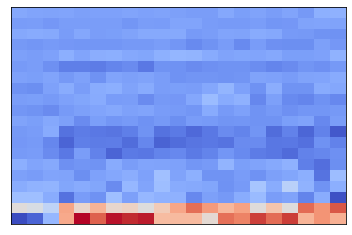

In [2]:
wave,sr=librosa.load('../audio/bahgat/00.wav',sr=22050)
print('audio duration :',librosa.get_duration(wave, sr=sr))
spec=librosa.feature.mfcc(y=wave, sr=sr, n_fft=22050, hop_length=11025)
librosa.display.specshow(spec)

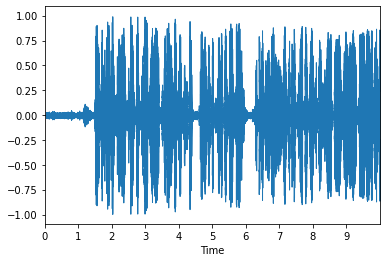

In [3]:
librosa.display.waveplot(wave, sr=sr)

In [6]:
def get_data(path,label):
    x=[]
    y=[]
    for audiopath in glob.glob(path+'*'):
        try:
            wave,sr=librosa.load(audiopath,sr=22050)
            if int(librosa.get_duration(wave, sr=sr)) !=10:
                continue
            spec=librosa.feature.mfcc(y=wave, sr=sr, n_fft=22050, hop_length=11025).T
            x.append(spec)
            y.append(label)
        except:
            pass
    return np.array(x),np.array(y)

In [10]:
bx,by=get_data(path='../audio/bahgat/',label=1)
nbx,nby=get_data(path='../audio/no bahgat/',label=0)

In [11]:
x=np.concatenate([bx,nbx]).astype(np.float32)
y=np.concatenate([by,nby]).astype(np.float32)

In [12]:
x,y = shuffle(x, y)
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.1)

In [17]:
np.save('saved/x_train.npy',x_train)
np.save('saved/y_train.npy',y_train)
np.save('saved/x_test.npy',x_test)
np.save('saved/y_test.npy',y_test)

In [2]:
x_train=np.load('saved/x_train.npy')
y_train=np.load('saved/y_train.npy')
x_test=np.load('saved/x_test.npy')
y_test=np.load('saved/y_test.npy')

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(336, 21, 20)
(336,)
(38, 21, 20)
(336,)


In [15]:
inputt = tf.keras.layers.Input((21,20))
l1=tf.keras.layers.LSTM(128)(inputt)
d=tf.keras.layers.Dense(128)(l1)
d=tf.keras.layers.Dense(1,activation='sigmoid')(d)
model=tf.keras.Model(inputt,d)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 21, 20)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 92,929
Trainable params: 92,929
Non-trainable params: 0
_________________________________________________________________


In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt)

In [17]:
model.fit(x_train,y_train,batch_size=32,epochs=100,validation_data=(x_test,y_test),
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Train on 336 samples, validate on 38 samples
Epoch 1/100
336/336 [==============================] - 5s 16ms/sample - loss: 0.7622 - val_loss: 0.6484
Epoch 2/100
336/336 [==============================] - 1s 3ms/sample - loss: 0.4907 - val_loss: 0.5608
Epoch 3/100
336/336 [==============================] - 2s 6ms/sample - loss: 0.3142 - val_loss: 0.4028
Epoch 4/100
336/336 [==============================] - 2s 7ms/sample - loss: 0.1875 - val_loss: 0.3132
Epoch 5/100
336/336 [==============================] - 3s 8ms/sample - loss: 0.1057 - val_loss: 0.2617
Epoch 6/100
336/336 [==============================] - 3s 8ms/sample - loss: 0.0634 - val_loss: 0.2294
Epoch 7/100
336/336 [==============================] - 3s 8ms/sample - loss: 0.0358 - val_loss: 0.1804
Epoch 8/100
336/336 [==============================] - 2s 7ms/sample - loss: 0.0214 - val_loss: 0.1654
Epoch 9/100
336/336 [==============================] - 3s 7ms/sample - loss: 0.0153 - val_loss: 0.1583
Epoch 10/100
336/336 [=====

<AxesSubplot:>

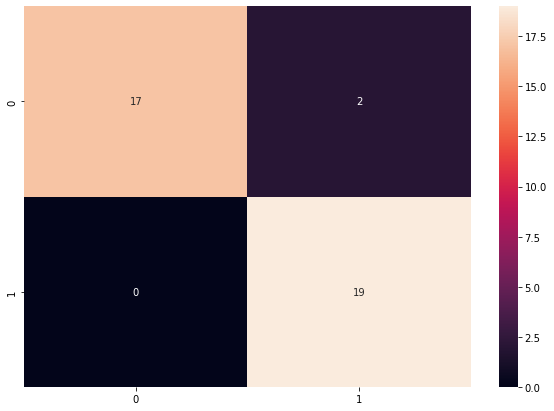

In [18]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix( y_test, np.round(model.predict(x_test)[:,0]) ), annot=True)

In [19]:
model.save('saved/my_model.h5')

In [3]:
model=tf.keras.models.load_model('saved/my_model.h5')

In [27]:
#segment the audio to 10 seconds clibs and predict it ()
test_wave,sr=librosa.load('test/test.mp3',sr=22050)
for i in range(0,int((librosa.get_duration(test_wave, sr=sr)//10)*10),10):
    test_sub_wave=test_wave[i*sr:(i+10)*sr]
    test_spec=librosa.feature.mfcc(y=test_sub_wave, sr=sr, n_fft=22050, hop_length=11025).T.reshape(1,21,20)
    pred=model.predict(test_spec)
    print(i,' - ',i+10,' : ',pred[0,0])

0  -  10  :  0.27660942
10  -  20  :  0.49709892
20  -  30  :  0.9996475
30  -  40  :  0.37903127
40  -  50  :  0.9983847
